
### Cluster Validation Pipeline for LSST
Assess the performance of optical cluster finders for sanity checks on LSST data 

Compares/Matches an input Optical catalog to a well-centered X-Ray cluster catalog and the SPT 2500d SZ cluster catalog and performs the   following:

- Finds cross matches between the optical input and the two truth catalogs using ClEvaR
  - Matches are found based off of a specificed offset radius and redshift range
  - Completeness Plot for SPT/Optical
- Takes the sample of matched Optical/X-Ray Clusters and calculates the distance between the Optical and X-Ray centers
  - Fits a two-component gamma distribution model to the well-centered and miscentered clusters
  - Creates a corner plot of parameter constraint distributions
  - Plots histogram of X-Ray peak to input catalog position offsets
- Fit scaling relations using the matched clusters between X-Ray temperature and richness, as well as SZ signal-to-noise ratio and richness
  - Fit is created using linmix
  - Option to run CluStR package for more explicit statistics 

 

In [1]:
# Imports and constants
from clevar.catalog import ClCatalog
from clevar.match import ProximityMatch
from clevar.cosmology import AstroPyCosmology
from clevar.match_metrics import recovery
from clevar.match import output_catalog_with_matching
from clevar.match import output_matched_catalog
import numpy as np
from astropy.cosmology import FlatwCDM
from astropy import units as u
from astropy.coordinates import SkyCoord
from astropy.io import fits
from astropy.table import Table
import pymc as pm
import pandas as pd
import pylab as plt
%matplotlib inline
from matplotlib import colors
from matplotlib.ticker import LogFormatter, ScalarFormatter, FormatStrFormatter
import scipy
import pyfiglet as pfig
import linmix
from scipy.stats import gamma
import corner
import matplotlib.lines as mlines
import os

cosmo = FlatwCDM(H0=70, Om0=0.3)

### 1. Proximity Matching with ClEvaR
- Parameters to the matching function will likely need to be changed in the "tags" section of the optical_match1 and optical_match2 definitions according to the appropriate names in the input catalog
- For this default example, we use the DES Y1 redMaPPer cluster catalog

In [2]:
def cross_matching(file_path_optical, file_path_xray, file_path_sz, match_radius_xray, redshift_window_xray,
                   match_radius_sz, redshift_window_sz, file_path_output):
    
    """
    Matches an input optical catalog with both a RASS-MCMF catalog of known well-centered X-ray clusters and the 
    SPT SZ 2500 deg2 catalog , according to specified matching criteria in radius and redshift. 
    The function outputs the matched catalogs to the designated file path.

    Parameters:
    -----------
    file_path_optical : str
        Path to the input optical catalog file.
    file_path_xray : str
        Path to the X-ray RASS catalog file.
    file_path_sz : str
        Path to the SPT-SZ catalog file.
    match_radius_xray : str
        Maximum radius (physical/angular) for matching between the optical and X-ray catalogs.
    redshift_window_xray : float
        Allowed redshift range for matching between the optical and X-ray catalogs.
    match_radius_sz : float
        Maximum radius (physical/angular) for matching between the optical and SZ catalogs.
    redshift_window_sz : float
        Allowed redshift range for matching between the optical and SZ catalogs.
    file_path_output : str
        Path where the output matched catalogs will be saved.

    Returns:
    --------
    matched_catalog_xray : ClCatalog
        The X-ray catalog with matched entries from the optical catalog.
    matched_catalog_sz : ClCatalog
        The SZ catalog with matched entries from the optical catalog.
    """
     
    # read catalogs and pick out necessary matching information, creates matching objects
    optical_match1 = ClCatalog.read(str(file_path_optical), 
                          "optical" ,
                          full = False, 
                          tags={"id": "ID", "ra": "RA", "dec": "DEC", "z": "Z_LAMBDA", "mass": "LAMBDA" })
    
    optical_match2 = ClCatalog.read(str(file_path_optical), 
                          "optical" ,
                          full = False, 
                          tags={"id": "ID", "ra": "RA", "dec": "DEC", "z": "Z_LAMBDA", "mass": "LAMBDA" })


    truth_match_xray = ClCatalog.read(str(file_path_xray), 
                          "truth_xray", 
                          full = False, 
                          tags={"id" : "mem_match_id", "ra": "x_ray_peak_ra", "dec": "x_ray_peak_dec", "red_RA": "redMaPPer_ra", 
                                "red_DEC": "redMaPPer_dec", "z": "Redshift", "mass": "r2500_temperature", "lamda": "lambda"})

    truth_match_sz = ClCatalog.read(str(file_path_sz), "truth_sz", 
                            full = False, 
                            tags={"id" : "SPT_ID", "ra" : "RA", "dec": "DEC", "mass" : "XI", "z" : "REDSHIFT"})

    mt = ProximityMatch()

    mt_config_xray = {'type': 'cross', # options are cross, cat1, cat2
    'which_radius': 'max', # Case of radius to be used, can be: cat1, cat2, min, max
    'preference': 'more_massive', # options are more_massive, angular_proximity or redshift_proximity
    'catalog1': {'delta_z': redshift_window_xray,
                'match_radius': str(match_radius_xray)
                },
    'catalog2': {'delta_z':redshift_window_xray,
                'match_radius': str(match_radius_xray)}}
    
    mt_config_sz = {'type': 'cross', # options are cross, cat1, cat2
    'which_radius': 'max', # Case of radius to be used, can be: cat1, cat2, min, max
    'preference': 'more_massive', # options are more_massive, angular_proximity or redshift_proximity
    'catalog1': {'delta_z': redshift_window_sz,
                'match_radius': str(match_radius_sz)
                },
    'catalog2': {'delta_z':redshift_window_sz,
                'match_radius': str(match_radius_sz)}}

    cosmo = AstroPyCosmology() #Need a cosmology if configuration radius is physical

    print("Matching input with X_Ray Truth Catalog for centering...")
    print ('\n')

    mt.match_from_config(optical_match1, truth_match_xray, mt_config_xray, cosmo=cosmo)

    # save and load matches
    mt.save_matches(optical_match1, truth_match_xray, out_dir="temp", overwrite=True)
    mt.load_matches(optical_match1, truth_match_xray, out_dir="temp")
    print ('\n')


    # write matches to catalog
    global match_file_path_xray
    global matched_catalog_xray

    output_catalog_with_matching(str(file_path_xray), 
                                 str(file_path_output) + 'xray_optical_crossmatch.fits', 
                                 truth_match_xray, overwrite = True)
    
    match_file_path_xray = str(file_path_output) + 'xray_Optical_crossmatch.fits'

    matched_catalog_xray = truth_match_xray

    print("Matching input with SPT-SZ Catalog for scaling relations...")
    print ('\n')

    mt.match_from_config(optical_match2, truth_match_sz, mt_config_sz, cosmo=cosmo)

    # save and load matches
    mt.save_matches(optical_match2, truth_match_sz, out_dir="temp", overwrite=True)
    mt.load_matches(optical_match2, truth_match_sz, out_dir="temp")

    # write matches to catalog
    global matched_catalog_sz
    global match_file_path_sz

    output_matched_catalog(str(file_path_optical), str(file_path_sz), str(file_path_output) + 'sz_optical_crossmatch.fits', optical_match2, truth_match_sz, matching_type = 'cross', overwrite = True)
    
    match_file_path_sz = str(file_path_output) + 'sz_optical_crossmatch.fits'

    matched_catalog_sz = truth_match_sz

    return matched_catalog_xray, matched_catalog_sz


In [3]:
cross_matching('/Users/es/Desktop/research_data/DES/redmapper_y1a1_public_v6.4_catalog.fits', 
               '/Users/es/Desktop/research_data/cluster_validation/matcha_rass_catalog_2024_07_snr25_declt20_zgt0.1_extra_clean.fits',
               '/Users/es/Desktop/research_data/cluster_validation/2500d_cluster_sample_spt.fits',
               '2 Mpc', 0.05, '2 Mpc', 0.05, '/Users/es/Desktop/research_data/cluster_validation/')


Matching input with X_Ray Truth Catalog for centering...



## ClCatalog 1
## Prep mt_cols
* zmin|zmax from config value
* ang radius from set scale

## ClCatalog 2
## Prep mt_cols
* zmin|zmax from config value
* ang radius from set scale

## Multiple match (catalog 1)
Finding candidates (optical)
* 30/6,729 objects matched.es

## Multiple match (catalog 2)
Finding candidates (truth_xray)
* 29/242 objects matched.

## Finding unique matches of catalog 1
Unique Matches (optical)
* 29/6,729 objects matched.

## Finding unique matches of catalog 2
Unique Matches (truth_xray)
* 29/242 objects matched.
Cross Matches (optical)
* 29/6,729 objects matched.
Cross Matches (truth_xray)
* 29/242 objects matched.
optical
    * ClEvar used in matching: 0.14.1
 * Total objects:    6,729
 * multiple (self):  30
 * multiple (other): 30
 * unique (self):    29
 * unique (other):   29
 * cross:            29

truth_xray
    * ClEvar used in matching: 0.14.1
 * Total objects:    242
 * multiple (self):  2

(<clevar.catalog.catalog.ClCatalog at 0x3094a7ed0>,
 <clevar.catalog.catalog.ClCatalog at 0x309478250>)

### 1.1 Recovery Fractions of Matched Clusters 

### 1.1b Optical/SZ Completeness

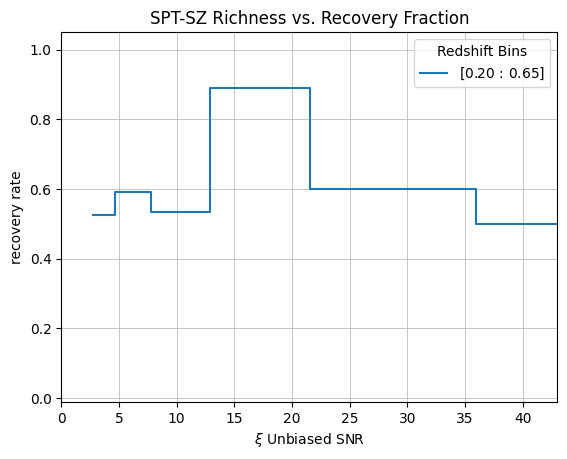

In [4]:
### recovery fractions as function of richness 

zbins = np.linspace(0.2, 0.65, 2)
mbins = np.logspace(0, 2, 10)
info = recovery.plot(matched_catalog_sz, "cross", zbins, mbins, shape="steps", transpose = True, mass_label = r"$\xi$" + " Unbiased SNR")
plt.title("SPT-SZ Richness vs. Recovery Fraction")
plt.legend(title = 'Redshift Bins')
plt.xscale("linear")
plt.xlim(0, 43)

#plt.savefig("/Users/es/Desktop/research_data/cluster_validation/matched_catalog_recovery_sz", dpi=300)

plt.show()

### 1.2 Format Matched Catalog for Centering

In [5]:
### need to cut out extraneous clusters still left in catalog with no match, remove NaNs

matched_catalog_xray = matched_catalog_xray[~np.isnan(matched_catalog_xray['mt_cross'].astype(float))]


### 2. Centering and Model-fit

### 2.1 Measure Distance Between Optical/X-Ray Centers 

In [6]:
def load_and_calculate(matched_catalog):

### Function taken from https://github.com/Jeltema-Group/centering

    """

    Calculates distances between X-Ray peak and Optical Centers of matched clusters

    Parameters:
    -----------
    matched_catalog : ClCatalog
        Optical/X-Ray or Optical/SZ catalogs with matching information.

    Returns:
    -----------
    match_dataframe:
        Pandas dataframe with centering distances.
        
    """
    
    data = pd.DataFrame()
    
    lambdas_match=matched_catalog['lambda']
    zs_match=matched_catalog['Redshift']
    rdmp_ra_match=matched_catalog['redMaPPer_ra']
    rdmp_dec_match=matched_catalog['redMaPPer_dec']
    xray_ra_match=matched_catalog['x_ray_peak_ra']
    xray_dec_match=matched_catalog['x_ray_peak_dec']
    
    #separations
    centr_match=SkyCoord(rdmp_ra_match, rdmp_dec_match, frame='icrs', unit='deg') # coordinates of the redmapper center
    coord_match=SkyCoord(xray_ra_match, xray_dec_match, frame='icrs', unit='deg') # coordinates of the x-ray center
    sep_match=centr_match.separation(coord_match).arcminute*u.arcmin
    psep_match=sep_match*cosmo.kpc_proper_per_arcmin(matched_catalog['Redshift']).to(u.Mpc/u.arcmin)
    roffs_match=psep_match.value
    rlmds_match=(0.01*lambdas_match)**0.2/0.7

    match_data = {
        'redshift':matched_catalog['Redshift'].byteswap().newbyteorder(),
        'lambdas':matched_catalog['lambda'].byteswap().newbyteorder(),
        'centr':SkyCoord(rdmp_ra_match, rdmp_dec_match, frame='icrs', unit='deg'), # coordinates of the redmapper center
        'coord':SkyCoord(xray_ra_match, xray_dec_match, frame='icrs', unit='deg'), # coordinates of the x-ray center
        'sep':centr_match.separation(coord_match).arcminute*u.arcmin,
        'psep':sep_match*cosmo.kpc_proper_per_arcmin(matched_catalog['Redshift']).to(u.Mpc/u.arcmin),
        'roffs':psep_match.value,
        'rlmds':(0.01*lambdas_match)**0.2/0.7
    }
    match_dataframe = pd.DataFrame(match_data)
    match_dataframe.attrs['telescope']='optical'

    return match_dataframe
    

In [7]:
data = load_and_calculate(matched_catalog_xray)

### 2.2 Model Definition

In [8]:
# Currently we use the non-logspace gamma distribution so we can 
# take the log of the whole thing at the end. We could potentially 
# switch to all-pymc modeling if we were clever about logarithms
# but that's also a bit of a risk since no one is clever about
# logarithms
def make_model(r_offset, rlambda):
    
### Function taken from https://github.com/Jeltema-Group/centering

    """
    Constructs a probabilistic model using PyMC to describe the X-Ray to Optical centering offsets using a 
    two component Gamma Distribution following Kelly et al.

    Parameters:
    -----------
    r_offset : array
        The offset between the true center and estimated center 
    rlambda : array
        The characteristic scale of the galaxy cluster, typically defined by richness (lambda).

    Returns:
    --------
    model : pm.Model
        A PyMC probabilistic model that defines the likelihood of observing centering offsets given 
        the model parameters for both centered and miscentered clusters.
    """
    
    with pm.Model() as model:
        rho_0 = pm.Uniform('Rho0', lower=0.3, upper=1)
        r0 = pm.Uniform('R0', lower=0.0001, upper=0.1)
        tau = pm.Uniform('tau', lower=0.04, upper=0.83)
        k = 2  # Consider making this a model parameter again if you feel adventurous

        r_rlam = r_offset / rlambda

        # Define the likelihood manually since PyMC4 does not have a direct method for custom stochastic functions
        def log_prob(r_rlam, rho_0, r0, tau, k):
            # Correctly calculating log probability
            log_pr_cor = pm.logp(pm.Gamma.dist(alpha=1, beta=1/r0), r_rlam)  # For "correct" centers
            log_pr_mis = pm.logp(pm.Gamma.dist(alpha=k, beta=1/tau), r_rlam)  # For miscentered clusters

            # Combining probabilities
            pr = pm.math.exp(log_pr_cor) * rho_0 + pm.math.exp(log_pr_mis) * (1 - rho_0)  # Combining corrected and miscentered
            log_pr = pm.math.log(pr)  # Log of total probability

            return log_pr

        # Use DensityDist for custom likelihoods
        pm.Potential('logprob', log_prob(r_rlam, rho_0, r0, tau, k))

    return model

### 2.3 Markov Chain Monte Carlo Sampling

In [9]:
### this is a modified version of the centering MCMC loop on the revamped_pymc4 branch from 
### https://github.com/Jeltema-Group/centering
### circumventing the data cuts to just run the fit on the dataframe of matches

def MCMC_loop(data, file_path_mcmc_ouput):

    """
    Runs MCMC fit on dataframe of Optical/X-Ray cross-matched centering offsets

    Args:
        data (pd.DataFrame): The input dataframe containing the matched centering offsets for MCMC fitting.
    
        file_path_mcmc_ouput (str): Path to the directory where MCMC output should be saved.

    Returns:
        output (list): A nested list containing the fitted parameter arrays [rho_0, r0, tau].

    Traces for Rho0, R0, and tau are saved to desired output file path
    """
    
    output = []
    lmd_cut_out = []
        
    lmd_min=[20]
    lmd_max=[9999999]
    z_min=[0.2]
    z_max=[0.65]
            
    r_offset=data['roffs']
    lmd=data['lambdas']
    rlmd=data['rlmds']
    print('data points: ' + str(len(r_offset)))

    mcmc_file= os.path.join(file_path_mcmc_ouput, 'mcmc_output/'+ str(data.attrs['telescope'])+'/lmd_'+str(lmd_min)+'_inf___z_'+str(z_min)+'_'+str(z_max))

    os.makedirs(mcmc_file, exist_ok=True) # make sure path exists

    model = make_model(r_offset, rlmd)
            
    with model:
        trace = pm.sample(draws=3000, tune=1000, return_inferencedata=False, progressbar=True)

        np.savetxt(f"{mcmc_file}/Rho0.txt", trace['Rho0'])  # Example: saving one parameter's trace
        np.savetxt(f"{mcmc_file}/R0.txt", trace['R0'])  # Example: saving one parameter's trace
        np.savetxt(f"{mcmc_file}/tau.txt", trace['tau'])  # Example: saving one parameter's trace
            
    global tau
    global rho_0
    global r0
            
    rho_0=np.loadtxt(mcmc_file+'/Rho0.txt')
    r0=np.loadtxt(mcmc_file+'/R0.txt')
    tau=np.loadtxt(mcmc_file+'/tau.txt')
            
    lmd_cut_out.append([rho_0, r0, tau])
    output.append(lmd_cut_out)
    return output

In [10]:
variables_out = MCMC_loop(data, '/Users/es/Desktop/research_data')

Initializing NUTS using jitter+adapt_diag...


data points: 29


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [Rho0, R0, tau]


Output()

Sampling 4 chains for 1_000 tune and 3_000 draw iterations (4_000 + 12_000 draws total) took 2 seconds.


### 3. Output Plots

### 3.1 Cornerplots

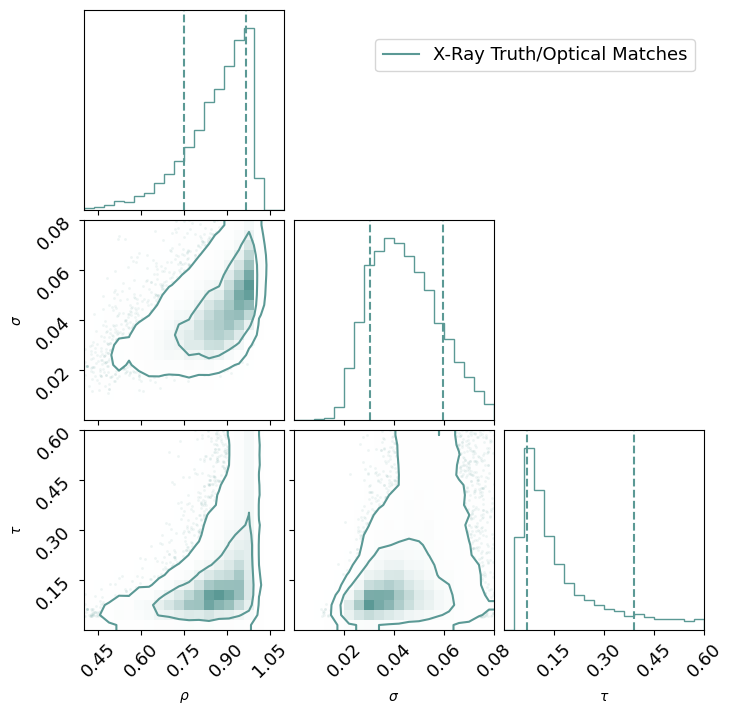

In [11]:
#creates a cornerplot of mcmc output for rho, sigma, and tau
#if legend is False then there will be no legend. 

samples = np.vstack([variables_out[0][0][0], variables_out[0][0][1], variables_out[0][0][2]]).T
figure = corner.corner(samples, levels=(0.68, 0.954), smooth = (0.16, 0.84), quantiles=(0.16, 0.84),color = '#5b9995', labels = [r"$\rho$", r"$\sigma$", r"$\tau$"], show_titles=False, plot_density=True, 
                       range = [(0.4, 1.1),(0,.08),(0, 0.6)]) #rho, sigma, tau

for ax in figure.get_axes():
        ax.tick_params(axis='both', labelsize=13)

#select the color
blue = mlines.Line2D([], [], color='#5b9995', label='X-Ray Truth/Optical Matches')
plt.legend(handles=[blue], bbox_to_anchor=(0., 1.0, 1., 2), loc=0, fontsize = 13)
#plt.savefig('/Users/es/Desktop/research_data/cluster_validation/X-Ray_Optical_corner_plot.png', dpi=500, format='png')
plt.show()

### 3.2 Centered/Miscentered Histogram

In [12]:
### averages rho_0, r0, and tau 
 
averaged_out = np.mean(variables_out, axis = 3)

results_no_cuts = pd.DataFrame(index = ['match'])
results_no_cuts['rho'] = np.array(averaged_out[0,0, 0])
results_no_cuts['rho_err'] = np.std(variables_out[0][0][0])
results_no_cuts['sigma'] = np.array(averaged_out[0,0, 1])
results_no_cuts['sigma_err'] = np.std(variables_out[0][0][1])
results_no_cuts['tau'] = np.array(averaged_out[0,0, 2])
results_no_cuts['tau_err'] = np.std(variables_out[0][0][2])


In [13]:
### Histogram
### plots the centered and miscentered fit over each other
### modified function taken from https://github.com/Jeltema-Group/centering
def plot(results):

    """
    Plots the distribution of well-centered and mis-centered clusters over eachother, 
    along with the joint sample data from Kelly et al.

    Parameters:
    -----------
    results : pd.Dataframe
        Dataframe containing the fitted parameters, along with their uncertainties from the MCMC chain

    --------
    """
    
    fig, axs = plt.subplots(figsize=(9,6))
    
    axs.hist(data['roffs'],color='blueviolet',alpha=0.5,density=True,label='X-Ray/Optical sample')   
        # density=True makes it a probability density; it gets normalized so the area
        # under the histogram is 1 and can be compared to the results of the fit
        # note: make "pr_cor" and "pr_mis" into their own functions for ease of use
    
    x = data['roffs']
    
    # well-centered clusters
    yc = (results['rho'].iloc[0])*gamma.pdf(x, 1, scale=results['sigma'].iloc[0]) 
    yc_up = (results['rho'].iloc[0]+results['rho_err'].iloc[0])*gamma.pdf(x, 1, scale=(results['sigma'].iloc[0]+results['sigma_err'].iloc[0]))
    yc_low = (results['rho'].iloc[0]-results['rho_err'].iloc[0])*gamma.pdf(x, 1, scale=(results['sigma'].iloc[0]-results['sigma_err'].iloc[0]))

    #miscentered clusters
    ym = (1-results['rho'].iloc[0])*gamma.pdf(x, 2, scale=results['tau'].iloc[0]) # mis-centered clusters
    ym_up = (1-(results['rho'].iloc[0]+results['rho_err'].iloc[0]))*gamma.pdf(x, 2, scale=(results['tau'].iloc[0]+results['tau_err'].iloc[0]))
    ym_low = (1-(results['rho'].iloc[0]-results['rho_err'].iloc[0]))*gamma.pdf(x, 2, scale=(results['tau'].iloc[0]-results['tau_err'].iloc[0]))

    # this step because the gamma function returns stuff all over the place! 
    xc,yc = zip(*sorted(zip(x,yc),key=lambda x: x[0]))
    xc_up, yc_up = zip(*sorted(zip(x,yc_up),key=lambda x: x[0]))
    xc_low, yc_low = zip(*sorted(zip(x,yc_low),key=lambda x: x[0]))

    xm,ym = zip(*sorted(zip(x,ym),key=lambda x: x[0]))
    xm_up, ym_up = zip(*sorted(zip(x,ym_up),key=lambda x: x[0]))
    xm_low, ym_low = zip(*sorted(zip(x,ym_low),key=lambda x: x[0]))

    # well-centered joint sample (Kelly et al.)
    sigma = 0.053 
    tau = 0.23
    rho = 0.87
    
    Pc_joint = rho*gamma.pdf(x, 1, scale = sigma) 
    Pm_joint = (1 - rho)*gamma.pdf(x, 2, scale = tau)

    xc_joint, Pc_joint = zip(*sorted(zip(x,Pc_joint), key = lambda x: x[0]))
    xm_joint, Pm_joint = zip(*sorted(zip(x,Pm_joint), key = lambda x: x[0]))

    # plotting
    
    axs.plot(xc,yc,c='k',label='Well-Centered Model')
    axs.fill_between(xc,yc_up,yc_low,color='k',alpha=0.4)

    axs.plot(xm,ym,c='r',label='Mis-Centered Model')
    axs.fill_between(xm,ym_up,ym_low,color='r',alpha=0.4)
    plt.ylim(0,10)
    plt.xlim(0, 0.5)
    axs.legend()

    axs.plot(xc_joint, Pc_joint, c = 'blue', label = "Kelly et al. Well-Centered Joint Sample")
    axs.plot(xm_joint, Pm_joint, c = 'Lime', label = "Kelly et al. Mis-Centered Joint Sample")
    axs.legend()
    
    axs.set_xlabel('$r_{offset}/R_{\lambda}$',fontsize = 20)
    axs.set_ylabel('Normed Dist.', fontsize = 20)
    
    #plt.savefig(str(filename)+'.png', dpi=300, format='png')

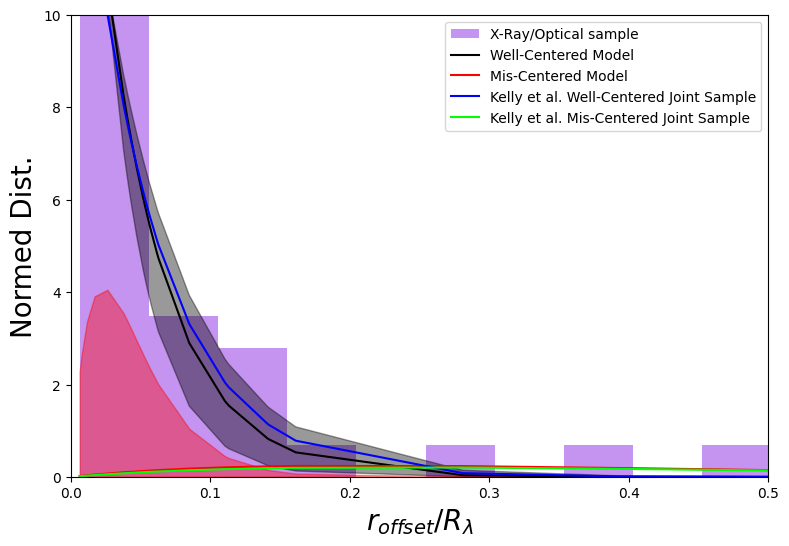

In [14]:
plot(results_no_cuts)

### 4.1 Scaling Relations
- Richness/Temperature and Richness/SZ Scaling Relations 

In [15]:
### function taken from CluStR package and implemented in Jupyter
### https://github.com/sweverett/CluStR
def run_linmix(x, y, err_x, err_y, Nmin=5000, Nmax=10000, vb=True, delta=None):
    # Runs the Kelly regression algorithm through the package linmix

    # Make sure dimensions are correct
    assert np.size(x) == np.size(y)
    assert np.size(err_x) == np.size(err_y)
    assert np.size(x) == np.size(err_x)

    L = np.size(x)

    # Run linmix MCMC
    xycov = np.zeros(L)
    model = linmix.LinMix(x, y, err_x, err_y, xycov, delta, 2, 2)
    model.run_mcmc(Nmin, Nmax, silent=vb)

    # return intercept, slope, intrinsic scatter
    intercept = model.chain['alpha']
    slope = model.chain['beta']
    sigma = np.sqrt(model.chain['sigsqr'])

    # Return fit parameters consistently with run_lrgs
    return (intercept, slope, sigma)

In [16]:
def scaling_plots(x_col, y_col, matched_file_path):
### function has been taken and modified from CluStR package
### https://github.com/sweverett/CluStR

    """
    Plots scaling relations using matched catalog data for specified independent (x_col) 
    and dependent (y_col) variables. Data is fit using linmix, Optionally plots Richness-SZ relation 
    if desired from (S. Grandis et al.) (commented out in the current implementation).

    Parameters:
    -----------
    x_col : str
        Column name for the independent variable in the saved matched catalog.
    
    y_col : str
        Column name for the dependent variable in the saved matched catalog.

    matched_file_path : str
        Path to the matched catalog file (FITS format) that contains the data to be plotted.

    """
    def Ez(z):
        Om = 0.3
        H_0 = 0.7
        h = H_0/100
        return np.sqrt(Om*(1.+z)**3 + h)
        
    # load data  
    catalog = Table.read(matched_file_path)

    x = catalog[x_col]
    y = catalog[y_col]
    
    try:
        x_err_low = catalog[x_col + '_err_low']
        x_err_high = catalog[x_col + '_err_high']
        x_err = (x_err_low + x_err_high) / 2.0
    except KeyError:
        print(f"Error columns for {x_col} not found. Defaulting to zero errors.")
        x_err = np.zeros_like(x)
        x_err_low = np.zeros_like(x)
        x_err_high = np.zeros_like(x)

    try:
        y_err_low = catalog[y_col + '_err_low']        
        y_err_high = catalog[y_col + '_err_high']
        y_err = (y_err_low + y_err_high) / 2.0
    except KeyError:
        print(f"Error columns for {y_col} not found. Defaulting to zero errors.")
        y_err = np.zeros_like(y)
        y_err_low = np.zeros_like(y)
        y_err_high = np.zeros_like(y)
        print('\n')

    # Size of original data
    N = np.size(x)
    assert N == np.size(y)

    # Cut out any NaNs
    cuts = ( (~np.isnan(x)) &
                         (~np.isnan(y)) &
                         (~np.isnan(x_err)) &
                         (~np.isnan(y_err)) &
                         (~np.isnan(x_err_low)) &
                         (~np.isnan(x_err_high)) &
                         (~np.isnan(y_err_low)) &
                         (~np.isnan(y_err_high)) 
                         )                 
    
    x = x[cuts]
    y = y[cuts]
    x_err = x_err[cuts]
    y_err = y_err[cuts]
    x_err_low = x_err_low[cuts]
    x_err_high = x_err_high[cuts]
    y_err_low = y_err_low[cuts]
    y_err_high = y_err_high[cuts]

    # Scale data by redshift
    try:
        redshift = catalog['Redshift'][cuts]
        x /= Ez(redshift)
        y /= Ez(redshift)
    except KeyError:
        print("Data will not be scaled by Ez")
        print('\n')
        
    print(f'Mean {x_col} error: {np.mean(x_err)}')
    print(f'Mean {y_col} error: {np.mean(y_err)}')
    print ('\n')

    # Fit data and run linmix
    
    log_x = np.log(x)
    log_y = np.log(y)
    log_x_err = np.log(x_err + x) - log_x
    log_y_err = np.log(y_err + y) - log_y

    xmin = np.min(log_x)
    xmax = np.max(log_x)

    kelly_b, kelly_m, kelly_sigsqr = run_linmix(x = log_x, y = log_y, err_x = log_x_err, err_y = log_y_err)

    mean_int = np.mean(kelly_b)
    mean_slope = np.mean(kelly_m)
    mean_sigsqr = np.mean(kelly_sigsqr)

    print(f"Mean Intercept: {np.mean(kelly_b)}")
    print(f"Mean Slope: {np.mean(kelly_m)}")
    print(f"Mean Variance: {np.mean(kelly_sigsqr)}")
    print('\n')
    print('Plotting..')

    # Scale fit to data and recover to cartesian

    scaled_x = np.linspace(0.5*xmin, 1.5*xmax, len(log_x))
    scaled_y = mean_int + mean_slope * scaled_x
    scaled_x_err = np.zeros(len(log_x))
    scaled_y_err = np.ones(len(log_y))*mean_slope

    unscaled_x = np.exp(scaled_x)
    unscaled_y = np.exp(scaled_y)
    unscaled_x_err = scaled_x_err * scaled_x
    unscaled_y_err = scaled_y_err * scaled_y

    # Scaling Relation between Unbiased SNR and Richness, (S. Grandis et al.)
    
    #def lambda_(xi, a):
       # A_lambda = a
       # B_lambda = 1.15
       # A_SZE = 5.24
       # B_SZE = 1.534
       # return A_lambda * ((xi/A_SZE) ** (B_lambda/B_SZE))

    # Plot Data

    fig, ax = plt.subplots()
    plt.errorbar(x, y, xerr = x_err, yerr = y_err, ecolor='k', fmt='bo', lw=1, markersize=2, markeredgecolor='k', capsize=1, label='_nolegend_')

    plt.loglog(unscaled_x, unscaled_y, color='blue', linewidth=2.0, label=(
            r'$({0:0.2g} \pm {1:0.2g})'
            r'(x)^{{{2:0.2f} \pm {3:0.2f}}}$'
        ).format(
            np.exp(np.mean(kelly_b)),
            np.exp(np.mean(kelly_b)) * np.std(kelly_b),
            np.mean(kelly_m),
            np.std(kelly_m),
            np.mean(kelly_sigsqr),
            np.std(kelly_sigsqr)
        )
    )
    # Scatter
    sigsqr = (np.mean(kelly_sigsqr))
    
    yLow_log = scaled_y - sigsqr
    yHigh_log = scaled_y + sigsqr
    
    yLow = np.exp(yLow_log)
    yHigh = np.exp(yHigh_log)


    plt.fill_between(unscaled_x, yLow, yHigh, color='gray', alpha=0.5, label= r'Intrinsic Scatter: $\sigma^2 = {0:0.2f} \pm {1:0.2f}$'.format(sigsqr,np.std(kelly_sigsqr)))

    # Richness-SZ relation if desired (S. Grandis et al.)
    
    #if matched_file_path == match_file_path_sz:
       #plt.loglog(unscaled_x, lambda_(unscaled_x, 72.4), color = 'Lime',linewidth = 2.0, label = "Richness-SZ Relation (Projection Model)")

       # yLow_SZ = lambda_(unscaled_x, 61.8) 
       # yHigh_SZ = lambda_(unscaled_x, 84)

       # plt.fill_between(unscaled_x, yLow_SZ, yHigh_SZ, color = 'green', alpha = 0.3, label = "Richness-SZ Relation Error")
    
    
    ax.set_xlabel(f'{x_col}', fontsize=10)
    ax.set_ylabel(f'{y_col}', fontsize=10)
    ax.set_xlim([0.7*np.min(x), 1.4*np.max(x)])
    ax.set_ylim([0.3*np.min(y), 1.9*np.max(y)])
    plt.xscale('log')
    plt.yscale('log')
    ax.tick_params(axis='both', which='major', direction='in', length=8, width=1.)
    ax.tick_params(axis='both', which='minor', direction='in', length=4, width=0.5)
    ax.xaxis.set_major_formatter(LogFormatter())
    ax.xaxis.set_minor_formatter(ScalarFormatter())
    ax.yaxis.set_major_formatter(LogFormatter())
    ax.yaxis.set_minor_formatter(ScalarFormatter())

    ax.grid(which='major', color='k', alpha=0.2)
    ax.grid(which='minor', color='k', alpha=0.1)
    ax.legend(loc='best', fontsize='x-small')

    #if matched_file_path == match_file_path_sz:
        #plt.savefig('/Users/es/Desktop/research_data/cluster_validation/Richness_SPT-SZ_Scaling_Relation.png', dpi=500, format='png')


    #if matched_file_path == match_file_path_xray:
        #plt.savefig('/Users/es/Desktop/research_data/cluster_validation/Richness_Temperature_Optical_Xray.png', dpi=500, format='png')



Error columns for cat2_XI not found. Defaulting to zero errors.
Error columns for cat1_LAMBDA not found. Defaulting to zero errors.


Data will not be scaled by Ez


Mean cat2_XI error: 0.0
Mean cat1_LAMBDA error: 0.0


Mean Intercept: 2.855074236241053
Mean Slope: 0.7314715389923514
Mean Variance: 0.35505641032263974


Plotting..


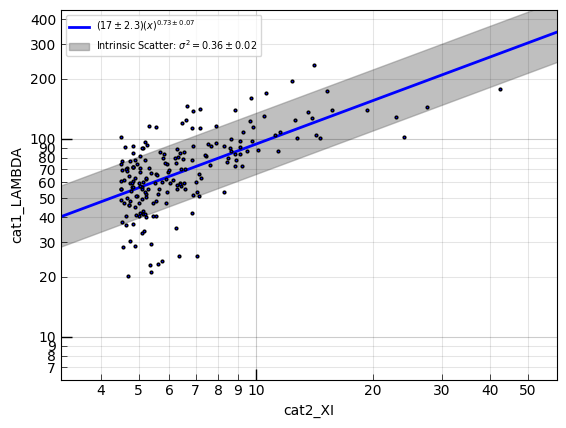

In [17]:
scaling_plots('cat2_XI', 'cat1_LAMBDA', match_file_path_sz)

Mean lambda error: 12.881937902439024
Mean r2500_temperature error: 0.5817791463975611


Mean Intercept: -0.48956691264499985
Mean Slope: 0.5195716769150694
Mean Variance: 0.2527789666909347


Plotting..


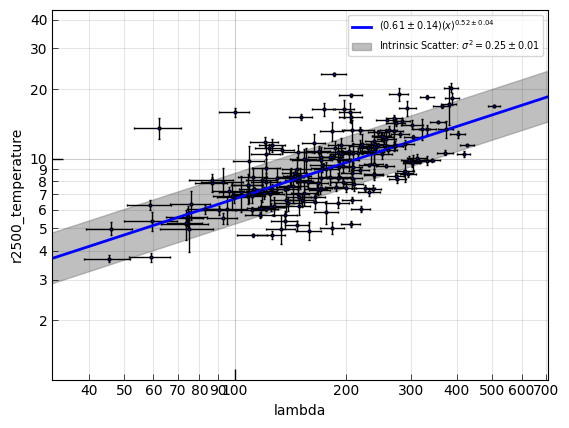

In [18]:
scaling_plots('lambda', 'r2500_temperature', match_file_path_xray)

### 4.2 Scaling Relations using CluStR Script and Packages
- In case flags/cuts or a specific configuration is desired, the CluStR script can be ran in the normal manner just be sure to change the file path
- If repeated use of CluStR is desired, it is recommended that CluStR be run in a separate terminal with the saved catalog of matches to avoid complications with running iPython environments in Jupyter, however for quick use this function should work just fine. It is possible to run CluStR in Jupyter as a subprocess, but plots will not appear in line.  

In [ ]:
### Runs CluStR as an ipython environment within Jupyter
### Parameters such as flags, cosmology, regression method, etc. can be changed as desired in the config.yml file
### be sure to update clustr.py file path

def run_clustr(x, y, config_file):
    %run -i /Users/es/CluStR/clustr.py {match_file_path_xray} {x} {y} {config_file}

# config currently ignores bool cuts and flags

# example richness vs. temperature
run_clustr(x = 'lambda', 
           y = 'tr2500', 
           config_file = '/Users/es/Desktop/research_data/cluster_validation/config.yml')

